In [1]:
import sys
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
import advertools as adv
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from num2words import num2words

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
import pickle
import re
import math
from scipy.special import logsumexp

In [2]:
rd_interaction = pd.read_csv('../ds_dataset/raw-data_interaction.csv')
rd_recipe = pd.read_csv('../ds_dataset/raw-data_recipe.csv')

In [3]:
def convert_lower_case(data):
    return np.char.lower(data)

In [4]:
def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [5]:
def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

In [6]:
def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
    

In [7]:
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    
    new_text = ""
    for w in tokens:

        for character in w:
            if character.isdigit():
                w = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", w)
        
        try:
            
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
        
    new_text = np.char.replace(new_text, "-", " ")
    
    return new_text

In [8]:
def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~"
    
    data = np.char.replace(data, " m\\n", ' minutes ' )
    data = np.char.replace(data, 'h\\', ' hours ')
    data = np.char.replace(data, ' h ', ' hours ')

    data = np.char.replace(data, "\\n", ' ')

    for i in range(len(symbols)):
        
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
        
    data = np.char.replace(data, ',', '')
    data = np.char.replace(data, ' f ', ' fahrenheit ')
    data = np.char.replace(data, ' c ', ' celcius ')
    data = np.char.replace(data, " u'", ' ' )

    return data

In [9]:
def remove_otherwords(data):
    data = np.char.replace(data, 'prep', ' ')
    data = np.char.replace(data, 'directions', ' ')
    return data

In [10]:
def preprocess(data):
    data = convert_lower_case(data)
    data = convert_numbers(data)
    data = remove_punctuation(data) #remove comma seperately
    data = convert_numbers(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_stop_words(data) #needed again as num2word is giving stop words 101 - one hundred and one
    return data

In [11]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return c

In [12]:
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

In [13]:
def gen_vector(tokens,dict_vocab,N):

    total_vocab = [x for x in dict_vocab]
    
    
    Q = np.zeros((len(total_vocab)))
    
    counter = Counter(tokens)
    words_count = len(tokens)

    query_weights = {}
    
    for token in np.unique(tokens):
        
        tf = counter[token]/words_count
        df = doc_freq(token)
        idf = math.log((N+1)/(df+1))

        try:
            ind = total_vocab.index(token)
            Q[ind] = tf*idf
        except:
            pass
        
    return Q

In [14]:
def cosine_similarity(k, query, dataset, dict_vocab, N):
    print("Computing Cosine Similarity....")
    preprocessed_query = preprocess(query)
    tokens = word_tokenize(str(preprocessed_query))
    
    
    #print("\nQuery:", query)
    #print("")
    #print(tokens)
    
    d_cosines = []
    
    query_vector = gen_vector(tokens, dict_vocab, N)

    
    
    for d in dataset:
        d_cosines.append(cosine_sim(query_vector, d))
        
    score = np.sort(np.array(d_cosines))[-k:][::-1]
    out = np.array(d_cosines).argsort()[-k:][::-1]
    
    
    #print("")
    
    #print(out)
    
    return out,score 

In [15]:
def print_recipe(row):
    print("Recipe name")
    print(preprocess(rd_recipe['recipe_name'][row]))
    print(" ")
    print("Cooking directions")
    print(preprocess(rd_recipe['cooking_directions'][row]))
    print(" ")
    print("Ingredients")
    print(preprocess(rd_recipe['ingredients'][row]))
    print(" ")


In [16]:
join_header = ['recipe_id', 'recipe_name']

rd_name = rd_recipe[join_header]
merged_inner = pd.merge(left=rd_name, right=rd_interaction)

def user_rate(user_id):
    filter = rd_interaction['user_id'] == user_id
    user_int = merged_inner.loc[filter, :]
    return user_int

2022-01-29 23:01:51,589 | INFO | category.py:227 | update | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2022-01-29 23:01:51,592 | INFO | category.py:227 | update | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


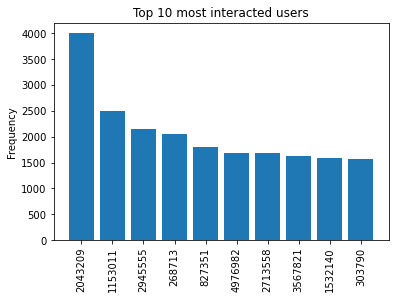

In [17]:
unique_id = rd_interaction['user_id'].unique()
int_count = rd_interaction['user_id'].value_counts()
top_10_id = int_count.head(10)
index_top10id = top_10_id.index.values.tolist()
id_string = [str(x) for x in index_top10id]

plt.bar(x=id_string, height=top_10_id.values)
plt.xticks(rotation='vertical')
plt.title("Top 10 most interacted users")
plt.ylabel("Frequency")
plt.show()

# Collecting fixed list of recipes

Selecting 20 recipes, 4 recipes corresponding to a query. 

No difference with Ganyi's test tbh

In [18]:
rd_interaction.head(5)

,user_id,recipe_id,rating,dateLastModified
0,8542392,222388,5,2017-04-22T12:46:43.663\r\n
1,11174581,222388,5,2013-06-20T15:50:25.96\r\n
2,8262477,222388,5,2015-02-14T07:27:51.307\r\n
3,3574785,240488,5,2017-10-07T18:20:08.973\r\n
4,12145410,240488,2,2018-01-06T00:06:09.563\r\n


In [19]:
user_df = user_rate(12145410)
rd_user = pd.merge(left=user_df, right=rd_recipe)
rd_user['ingredients'] = rd_user['ingredients'].apply(lambda x: preprocess(x))
rd_user.drop(columns = ["cooking_directions", "nutritions", "reviews", "image_url", "review_nums","aver_rate","dateLastModified"], inplace=True)

In [20]:
rd_user.to_csv('user_12145410.csv', index=True)

We will use this truncated dataset for our evaluation..

Query 1:  beef, salt, pepper (user-rate)  

Query 2: chicken, cream      (user-rate)

Query 3: noodles, chicken    (user-rate)

Query 4: beef, potatoes      (user-rate)

1 = fulfils query

0.5 = fulfils query but was not the user's preference

0 = does not fulfil query

In [22]:
eval_data = pd.read_csv('user_12145410_eval.csv')
header = ["recipe_id","cooking_directions"]
rd_dir = rd_recipe[header]
eval_df = pd.merge(left=eval_data, right=rd_dir)
#eval_df['cooking_directions'] = eval_df['cooking_directions'].apply(lambda x: preprocess(x))
#eval_df.set_index(keys="recipe_id", inplace=True)

In [23]:
eval_df.to_csv('model_dataset.csv', index=True)

In [24]:
eval_df.head(2)

,Index,recipe_id,recipe_name,user_id,rating,Query 1,Query 2,Query 3,Query 4,ingredients,cooking_directions
0,1.0,23567,Slow-Cooker Pepper Steak,12145410.0,5,1,0,0,0,beef sirloin garlic powder taste vegetable oi...,{'directions': u'Prep\n20 m\nCook\n4 h 10 m\nR...
1,2.0,221958,Chef John's Perfect Prime Rib,12145410.0,5,1,0,0,0,prime rib roast unsalted butter freshly groun...,{'directions': u'Prep\n10 m\nCook\n2 h 20 m\nR...


In [25]:
processed_sample = []
for text in eval_df['cooking_directions']:
    processed_sample.append(word_tokenize(preprocess(text)))

In [26]:

def vectorize_corpus(processed_text):	
	DF = {}

	N = len(processed_text)
	for i in range(N):
		tokens = processed_text[i]
    
		for w in tokens:
			#print(w)
			try:
				DF[w].add(i)
			except:
				DF[w] = {i}

	for i in DF:
		DF[i] = len(DF[i])
	
	total_vocab_size = len(DF)
	total_vocab = [x for x in DF]

	doc = 0

	tf_idf = {}

	for i in range(N):
    
		tokens = processed_text[i]
    
		counter = Counter(tokens)
		words_count = len(tokens)
    
		for token in np.unique(tokens):
        
			tf = counter[token]/words_count
			df = doc_freq(token)
			idf = np.log((N+1)/(df+1))
        
			tf_idf[doc, token] = tf*idf

		doc += 1
	
	D = np.zeros((N, total_vocab_size))
	for i in tf_idf:
		try:
			ind = total_vocab.index(i[1])
			D[i[0]][ind] = tf_idf[i]
		except:
			pass
	return D, DF , N

In [27]:
def print_eval(user_query, processed_text):   

    print("query is: " + user_query)
    [dataset, dict_vocab, N] = vectorize_corpus(processed_text)
    
    [Q,score] = cosine_similarity(7, user_query, dataset, dict_vocab, N)
    print("index,   recipe_id,    recipe name,   user rating,   similarity score")
    n = 0 
    for i in Q:
        recipname = preprocess(eval_df['recipe_name'][i])
        averate = np.around(eval_df['rating'][i],2)
        simscore = np.around(score[n]*100,2)
        recipid = eval_df['recipe_id'][i]
        print( str(i) + "   " + str(recipid) + "   " + str(recipname)  +  "   " +  str(averate) + "   " + str(simscore))
        n += 1

In [28]:
import sklearn.metrics as met

In [29]:
def eval_score(user_query, processed_text, query_num):
    [dataset, dict_vocab, N] = vectorize_corpus(processed_text)
    [Q,score] = cosine_similarity(10, user_query, dataset, dict_vocab, N)
    

    eval_reindex_df = eval_df.reindex(Q)

    

    header_name = str("Query ") + str(query_num)
    #eval_data_query = eval_data[header_name]
    relevancy = np.array(eval_reindex_df[header_name][0:7])
    ratingscore = np.array(eval_reindex_df['rating'][0:5])

    y_pred = [1,1,1,1,1,1,1]
    y_true = np.array(eval_reindex_df[header_name][0:7]) 
    print(relevancy)

    precision = met.precision_score(y_true, y_pred, average='weighted', zero_division = 0)
    recall = met.recall_score(y_true, y_pred, average='weighted' , zero_division = 0 )
    

    return  precision, recall

In [30]:
def query_class(num):
    if num == 1:
        user_query = "beef, salt, pepper"
    elif num == 2: 
        user_query = "chicken, cream"
    elif num == 3:
        user_query = "noodles, chicken"
    elif num == 4:
        user_query = "beef, potatoes"
    return user_query

In [31]:
print("Using the evaluation dataset...")

query_num = input("Enter a query number (1-4):")
user_query = query_class(int(query_num))
print_eval(user_query,processed_sample)

[prec , recal ] = eval_score(user_query, processed_sample, query_num)

print("")
print("Precision: {}  Recall: {}".format(np.around(prec,2) , np.around(recal,2) ))

Using the evaluation dataset...
query is: chicken, cream
Computing Cosine Similarity....
index,   recipe_id,    recipe name,   user rating,   similarity score
17   8964    chicken la charlie   3   56.25
35   8532    easy cheesy chicken   3   47.43
31   8797    lizzy creamy chicken bake   3   43.99
29   241716    chicken francesa   3   42.54
30   218621    easy creamy chicken casserole   3   42.52
32   244641    simple easy coq au vin   3   41.16
27   240900    mike maple chicken   3   38.57
Computing Cosine Similarity....
[1 1 1 0 1 0 0]

Precision: 0.33  Recall: 0.57
